In [32]:
%matplotlib inline
import os
import cv2  
import warnings
import numpy as np
import pandas as pd
import seaborn as sn 

sn.set(font_scale=1.4)
warnings.filterwarnings('ignore')

import tensorflow as tf                
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import keras
from keras import metrics
from keras import backend as K
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionResNetV2, ResNet50, Xception, VGG19
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, LambdaCallback, Callback

In [2]:
# TODO
# Take it to google colab
# EPOCH setting, Batch setting
# Hyperparmeters?
# Finding out which classes are not performing well? Check History
# cutout and gridmask
# Callbacks Usage
# trainable pretrained
# new notebook with different flow of data

### Preprocessing

In [34]:
TRAIN_PATH = 'dataset/Train Images/'
TEST_PATH = 'dataset/Test Images/'

IMAGE_SHAPE = (80, 80)
IMAGE_SHAPE_FULL = (80, 80, 3)
RESIZE_FACTOR = 255
EPOCHS = 20
BATCH_SIZE = 32

In [3]:
def load_file(row, path, shape, scale):
    
    filename = row['Image']        
    img = cv2.imread(os.path.join(path, filename))                        
    img = cv2.resize(img, shape)
    img = np.array(img)
    row['image_val'] = img/scale
        
    return row

In [5]:
train_ = pd.read_csv('dataset/train.csv')
test_ = pd.read_csv('dataset/test.csv')
train_.head()

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire


In [6]:
msk = np.random.rand(len(train_)) < 0.9
valid_df = train_[~msk]
train_df = train_[msk]

In [7]:
print(valid_df.shape, train_df.shape)

(594, 2) (5389, 2)


In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./RESIZE_FACTOR,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./RESIZE_FACTOR)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_PATH,
        x_col="Image",
        y_col="Class",
        target_size=IMAGE_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=TRAIN_PATH,
        x_col="Image",
        y_col="Class",
        target_size=IMAGE_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 5389 validated image filenames belonging to 4 classes.
Found 594 validated image filenames belonging to 4 classes.


In [9]:
class_names_label = train_generator.class_indices
class_label_names = {v: k for k, v in class_names_label.items()}
class_names = list(class_names_label.keys())
print(class_label_names)
print(class_names_label)
nb_classes = len(class_names_label)

{0: 'Attire', 1: 'Decorationandsignage', 2: 'Food', 3: 'misc'}
{'Attire': 0, 'Decorationandsignage': 1, 'Food': 2, 'misc': 3}


In [10]:
# For Visualisation only
train_['image_val'] = None
train_ = train_.apply(load_file, args=(TRAIN_PATH, IMAGE_SHAPE, RESIZE_FACTOR,), axis=1)
train_['labels'] = train_['Class'].apply(lambda x: class_names_label[x])
test_ = test_.apply(load_file, args=(TEST_PATH, IMAGE_SHAPE, RESIZE_FACTOR,), axis=1)

### Data Exploration

In [11]:
n_train = train_.shape[0]
n_test = test_.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SHAPE_FULL))

Number of training examples: 5983
Number of testing examples: 3219
Each image is of size: (80, 80, 3)


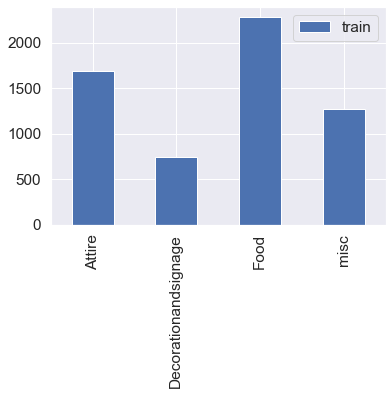

In [12]:
_, train_counts = np.unique(train_['Class'], return_counts=True)
pd.DataFrame({'train': train_counts}, index=class_names).plot.bar()
plt.show()

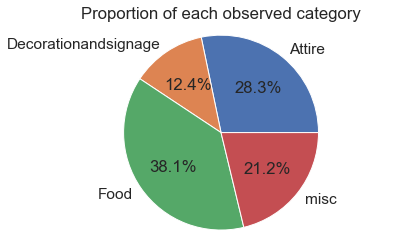

In [13]:
plt.pie(train_counts, explode=(0, 0, 0, 0), labels=class_names, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [14]:
def display_image(image, label):    
    plt.figure()
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image Predicted to be: ' + label)
    plt.show()

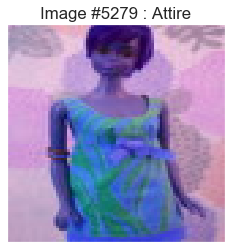

In [15]:
def display_random_image(images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + labels[index])
    plt.show()

display_random_image(train_['image_val'], train_['Class'])

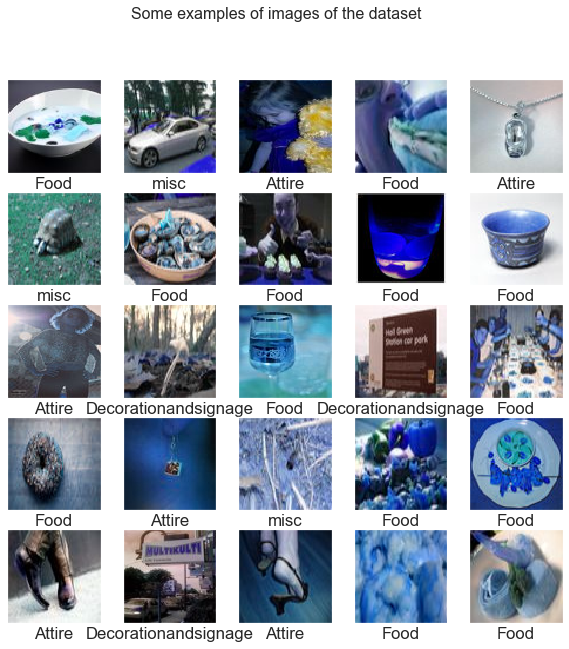

In [16]:
def display_examples(images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()
    
display_examples(train_['image_val'], train_['Class'])    

### Data Modelling

In [47]:
def create_model(input_shape, num_classes): 
    
    pretrain_model = VGG19(include_top=False, 
                           weights='imagenet', 
                           input_shape=input_shape, 
                           pooling='avg')  
    
    pretrain_model.trainable = False
        
    input_tensor = Input(shape=input_shape)
#     bn = BatchNormalization()(input_tensor)
    x = pretrain_model(input_tensor)
#     x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_tensor)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)    
#     x = Flatten()(x)    
    x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(input_tensor, output)    
    
    return model


In [52]:
keras.backend.clear_session()
model = create_model(input_shape=IMAGE_SHAPE_FULL, num_classes=nb_classes)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 20,156,740
Trainable params: 132,356
Non-trainable params: 20,024,384
_________________________________________________________________


In [53]:
earlystop = EarlyStopping(monitor='val_loss', patience=3)

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [earlystop, reduce_learning_rate]

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [54]:
history = model.fit_generator(train_generator, 
                              epochs=EPOCHS,
                              steps_per_epoch=train_generator.samples//BATCH_SIZE,                              
                              validation_data=validation_generator, 
                              validation_steps=validation_generator.samples//BATCH_SIZE, 
                              )

Epoch 1/20
168/168 [==============================] - 33s 198ms/step - loss: 1.0921 - accuracy: 0.5165 - val_loss: 0.9945 - val_accuracy: 0.5764
Epoch 2/20
168/168 [==============================] - 49s 294ms/step - loss: 0.9519 - accuracy: 0.5988 - val_loss: 0.8714 - val_accuracy: 0.6050
Epoch 3/20
168/168 [==============================] - 68s 407ms/step - loss: 0.9208 - accuracy: 0.6194 - val_loss: 1.1267 - val_accuracy: 0.6139
Epoch 4/20
168/168 [==============================] - 86s 511ms/step - loss: 0.8994 - accuracy: 0.6274 - val_loss: 0.8549 - val_accuracy: 0.6050
Epoch 5/20
168/168 [==============================] - 70s 416ms/step - loss: 0.8692 - accuracy: 0.6468 - val_loss: 1.1515 - val_accuracy: 0.6210
Epoch 6/20
168/168 [==============================] - 71s 424ms/step - loss: 0.8436 - accuracy: 0.6556 - val_loss: 0.8646 - val_accuracy: 0.6014
Epoch 7/20
168/168 [==============================] - 72s 428ms/step - loss: 0.8200 - accuracy: 0.6674 - val_loss: 0.7508 - val_ac

In [55]:
now = datetime.now()
model.save('models/model_' + str(now) + '.h5')

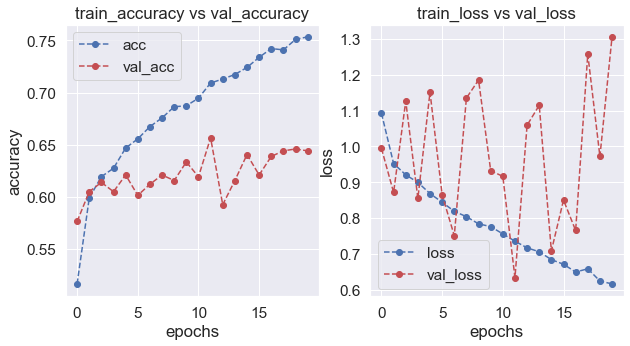

In [56]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_accuracy vs val_accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(122)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
    
plot_accuracy_loss(history)    

[[0.01173969 0.6933601  0.21021596 0.0846843 ]]


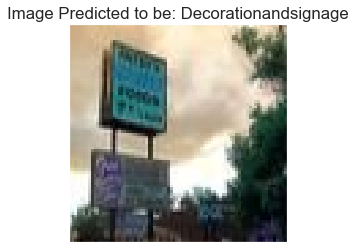

In [64]:
# Simple Testing
img_ = test_['image_val'][11]
img = img_[np.newaxis]
preds = model.predict(img)
print(preds)
pred_labels = np.argmax(preds)
img_label = class_label_names[pred_labels]
display_image(img_, img_label)

In [58]:
def pred(row):
    
    img_ = row['image_val']
    img = img_[np.newaxis]
    preds = model.predict(img)    
    pred_labels = np.argmax(preds)
    row['Class'] = class_label_names[pred_labels]            
    
    return row

test_['Class'] = None
test_ = test_.apply(pred, axis=1)

In [59]:
test_.head()

,Image,image_val,Class
0,image6245.jpg,"[[[0.9921568627450981, 0.984313725490196, 0.98...",Decorationandsignage
1,image10409.jpg,"[[[0.0, 0.0, 0.011764705882352941], [0.0, 0.0,...",Food
2,image8692.jpg,"[[[0.3333333333333333, 0.36470588235294116, 0....",Food
3,image10517.jpg,"[[[0.4, 0.17647058823529413, 0.207843137254901...",Food
4,image2580.jpg,"[[[0.34901960784313724, 0.34901960784313724, 0...",Attire


In [60]:
submit = test_[['Image', 'Class']]
submit.to_csv('submissions/submission_' + str(now) + '.csv', index=False)
submit.head()

,Image,Class
0,image6245.jpg,Decorationandsignage
1,image10409.jpg,Food
2,image8692.jpg,Food
3,image10517.jpg,Food
4,image2580.jpg,Attire


In [ ]:
# WASTE CODE

#     bn = BatchNormalization()(input_tensor)
#     x = Conv2D(32, kernel_size=(3, 3), padding='same',cactivation='relu')(x)
#     x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = Dropout(0.25)(x)
#     x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
#     x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = Dropout(0.25)(x)
#     x = Flatten()(x)    
#     x = Dense(512, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     output = Dense(num_classes, activation='softmax')(x)

# Splitting Training data into train and validation dataset
# x_train, x_val, y_train, y_val = train_test_split(train_images,train_labels,random_state=1)

# train_categories = keras.utils.to_categorical(train_['labels'], nb_classes)
# train_categories

In [ ]:
# if not data_augmentation:
#     print('Not using data augmentation.')
#     model.fit(x_train, y_train,
#               batch_size=batch_size,
#               epochs=epochs,
#               validation_data=(x_test, y_test),
#               shuffle=True)
# else:
#     print('Using real-time data augmentation.')
#     # This will do preprocessing and realtime data augmentation:
#     datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         zca_epsilon=1e-06,  # epsilon for ZCA whitening
#         rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#         # randomly shift images horizontally (fraction of total width)
#         width_shift_range=0.1,
#         # randomly shift images vertically (fraction of total height)
#         height_shift_range=0.1,
#         shear_range=0.,  # set range for random shear
#         zoom_range=0.,  # set range for random zoom
#         channel_shift_range=0.,  # set range for random channel shifts
#         # set mode for filling points outside the input boundaries
#         fill_mode='nearest',
#         cval=0.,  # value used for fill_mode = "constant"
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False,  # randomly flip images
#         # set rescaling factor (applied before any other transformation)
#         rescale=None,
#         # set function that will be applied on each input
#         preprocessing_function=None,
#         # image data format, either "channels_first" or "channels_last"
#         data_format=None,
#         # fraction of images reserved for validation (strictly between 0 and 1)
#         validation_split=0.0)
    